In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.decomposition import PCA
np.set_printoptions(suppress=True)

# Reference / Code base: Python for Multivariate Analysis, Gatsoulis, 2016
# https://github.com/gatsoulis/a_little_book_of_python_for_multivariate_analysis/blob/master/a_little_book_of_python_for_multivariate_analysis.ipynb
# Theory: The PCA analysis goal is to achieve the best lowest # of dimensions / factors describing the variance
# in the multivariate time series. The new PCA variables can be a combination of some or all original regressors. 
# Objective: reduce a number of factors explaining the data 

t = 150 # days
n = 10 # tickers
# Load sample data
tickers  = ["FB","MSFT","AAPL", "AMZN","GOOG","GS","MS","BAC","WFC","C"]  
tickers2  = ["JPM"]  
d1 = pickle.load(open("/home/ubuntu/portfolio/factors/stock_data.pkl","rb"))
d2 = d1[d1["ticker"].isin(tickers)][["Close","ticker"]]
ts_df = d2.reset_index().pivot(index="Date", columns='ticker', values='Close')[-504:] 
X = ts_df.values
# *** NORMALIZE ****
X = X.astype('float32')
X = np.nan_to_num(np.diff(np.log(X), axis=0))  # Replace nan with zero and inf with finite numbers.
X = 1 / (1 + np.exp( (X - X.mean()) / X.std() )  )

d2 = d1[d1["ticker"].isin(tickers2)][["Close","ticker"]]
ts_df = d2.reset_index().pivot(index="Date", columns='ticker', values='Close')[-504:] #252
y = ts_df.values
y = y.astype('float32')
y = np.nan_to_num(np.diff(np.log(y), axis=0))  # Replace nan with zero and inf with finite numbers.
y = 1 / (1 + np.exp( (y - y.mean()) / y.std() )  )

def pca_summary(pca, X):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = np.std(pca.transform(X), axis=0)
    a = np.reshape(a,[a.shape[0],-1])
    v = a **2
    b = pca.explained_variance_ratio_
    b = np.reshape(b,[b.shape[0],-1])
    c = np.cumsum(pca.explained_variance_ratio_)
    c = np.reshape(c,[c.shape[0],-1])
    columns = ["StDev", "Variance", "Proportion of Variance","Cumulative Proportion"]
    summary = pd.DataFrame(data = np.concatenate([a,v, b,c], axis=1), index=names, columns=columns)
    print("Importance of components:")  #eigenvectors/principal components
    return summary

pca = PCA(n_components=3)
pca.fit(X,y)  #  training data, target labels to explain by PCA 
d = pca_summary(pca, X)
print(d)
# Loadings for the Principal Components (first three Eigenvectors)

Importance of components:
        StDev  Variance  Proportion of Variance  Cumulative Proportion
PC1  0.465746  0.216920                0.610747               0.610747
PC2  0.240621  0.057899                0.163016               0.773762
PC3  0.146643  0.021504                0.060546               0.834308


In [2]:
# All principle components (non filtered)
pca = PCA()
pca.fit(X,y)  #  training data, target labels to explain by PCA 
d = pca_summary(pca, X)
print(d) # First 3 PCs explain 83.4% of dataset returns variance...

Importance of components:
         StDev  Variance  Proportion of Variance  Cumulative Proportion
PC1   0.465746  0.216920                0.610747               0.610747
PC2   0.240621  0.057899                0.163016               0.773762
PC3   0.146643  0.021504                0.060546               0.834308
PC4   0.119116  0.014189                0.039949               0.874257
PC5   0.113030  0.012776                0.035971               0.910228
PC6   0.098639  0.009730                0.027394               0.937622
PC7   0.090947  0.008271                0.023289               0.960911
PC8   0.078805  0.006210                0.017485               0.978396
PC9   0.063431  0.004024                0.011328               0.989724
PC10  0.060413  0.003650                0.010276               1.000000


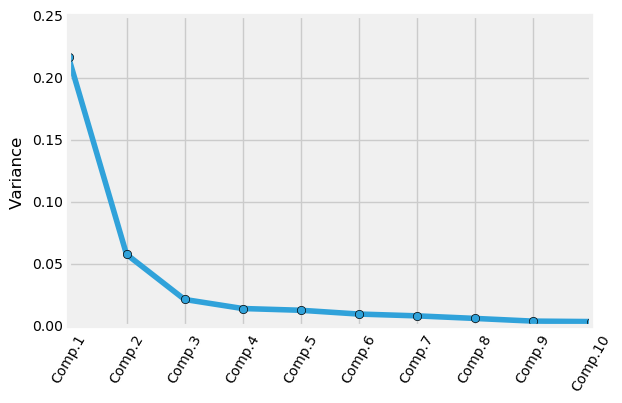

In [3]:
# Show how PCs explain dataset variance...
y = np.std(pca.transform(X), axis=0)**2
x = np.arange(len(y)) + 1
plt.plot(x, y, "o-")
plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
plt.ylabel("Variance")
plt.show()

In [4]:
# PC loadings 
print(pca.components_[0])
print(pca.components_[1])
print(pca.components_[2])

[-0.2465682  -0.26365367 -0.37998663 -0.38455798 -0.25379034 -0.24117375
 -0.36275844 -0.39779941 -0.26983553 -0.30363235]
[ 0.24437071  0.46214387 -0.30719897 -0.2560316   0.43888575  0.38064916
 -0.2180163  -0.2581693   0.27178067 -0.20302929]
[-0.87498396  0.40626547  0.0893408   0.02989671  0.10079174  0.17792507
 -0.00896691  0.03599074 -0.12031007  0.05300273]


In [5]:
# Regressors: PC linear combination of variables as below..
# i.e. for PC1 value is: ["FB","MSFT","AAPL", "AMZN","GOOG","GS","MS","BAC","WFC","C"]
#[-0.24656828*FB Norm Ret +  -0.26365367*MSFT Norm Ret + -0.37998663*AAPL Norm Ret +
# -0.38455798*AMZN Norm Ret + -0.25379034*GOOG Norm Return + -0.24117375*GS Norm Return +
# -0.36275844*MS Norm Ret + -0.39779941*BAC Norm Ret + -0.26983553*WFC Norm Ret + -0.30363235*C Norm Ret]
# one can then calculate PC values given linear factor loadings, etc...